In [1]:
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #解决运行时内核崩溃
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt

torch.set_printoptions(2)

**锚框的宽度和高度分别是 $ws\sqrt{r}$ 和 $hs/ \sqrt{r}$ 我们只考虑组合：**  
$(s_1,r_1),(s_1,r_2),...,(s_1,r_m),(s_2,r_1),(s_3,r_1),...,(s_n,r_1)$  
w和h是输入图片的宽和高，s表示锚框占图片的百分之多少(scale)，r是锚框的高宽比(ratio)  
上面这个组合的意思是，如果给出了n个s和m个r，不会尝试n*m个组合，而是拿第一个s和全部r组合，拿全部s和第一个r组合，总共有n+m-1个组合（每个像素点有这么多个锚框）  
**注意，老师说r是高宽比，但是通常大家认为r是宽高比，因此在.md中我写了这里的宽高公式反了，但又没反**

In [2]:
def multibox_prior(data,sizes,ratios):
    """生成以每个像素为中心具有不同高宽度的锚框"""
    # data.shape的最后两个元素为宽和高，第一个元素为通道数
    in_height, in_width = data.shape[-2:]
    # 数据对应的设备、锚框占比个数、锚框高宽比个数
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    # 计算每个像素点对应的锚框数量
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    # 将锚框占比列表转为张量并将其移动到指定设备
    size_tensor = torch.tensor(sizes, device=device)
    # 将宽高比列表转为张量并将其移动到指定设备
    ratio_tensor = torch.tensor(ratios, device=device)
    
    # 定义锚框中心偏移量
    offset_h, offset_w = 0.5, 0.5
    # 计算高度方向上的步长
    steps_h = 1.0 / in_height
    # 计算宽度方向上的步长
    steps_w = 1.0 / in_width
    
    # 生成归一化的高度和宽度方向上的像素点中心坐标
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    # 生成坐标网格
    shift_y, shift_x = torch.meshgrid(center_h, center_w,indexing='ij')
    # 将坐标网格平铺为一维
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    
    # 计算每个锚框的宽度和高度
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                  sizes[0] * torch.sqrt(ratio_tensor[1:]))) \
                    * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                  sizes[0] / torch.sqrt(ratio_tensor[1:])))
    
    # 计算锚框的左上角和右下角坐标（相对于锚框中心的偏移量）
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
    '''
    torch.stack:新增一个维度把输入的张量堆起来
    .repeat(num1,num2):第0维重复num1次，第1维重复num2次
    '''
    # 计算所有锚框的中心坐标，每个像素对应boxes_per_pixel个锚框
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    '''关于torch.stack的dim参数在md文件中写了一些自己的理解'''
    # 通过中心坐标和偏移量计算所有锚框的左上角和右下角坐标
    output = out_grid + anchor_manipulations
    
    # 增加一个维度并返回结果
    return output.unsqueeze(0)

**返回锚框变量`Y`的形状**

In [3]:
img = plt.imread('img/catdog.jpg')
print("img.shape：",img.shape) # 高561，宽72，3通道
h, w = img.shape[:2]
print(h,w)

X = torch.rand(size=(1,3,h,w)) # 批量大小为1,3通道
Y = multibox_prior(X, sizes=[0.75,0.5,0.25], ratios=[1,2,0.5]) # 占图片sizes尺寸的大小、高宽比ratios尺寸大小的锚框
print(Y.shape) # 1 是批量大小，2042040是一张图片生成的锚框数量，4个元素时每个锚框对应的位置

img.shape： (561, 728, 3)
561 728
torch.Size([1, 2042040, 4])


**访问以(250,250)为中心的第一个锚框**

In [4]:
boxes = Y.reshape(h,w,5,4)  # 上面的sizes×sizes=3×3，3+3-1=5，故每个像素为中心生成五个锚框    
boxes[250,250,0,:] # 以250×250为中心的第一个锚框的坐标

tensor([0.06, 0.07, 0.63, 0.82])

**访问以一个像素为中心的所有锚框**

In [5]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        # 如果obj为None，使用默认值；如果obj不是列表或元组，将其转换为列表
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    # 处理labels，确保其为列表形式
    labels = _make_list(labels) 
    # 处理colors，确保其为列表形式
    colors = _make_list(colors, ['b','g','r','m','c']) 
    # 遍历所有边界框
    for i, bbox in enumerate(bboxes): 
        # 选择颜色
        color = colors[i % len(colors)] 
        # 使用边界框和颜色生成矩形框
        rect = d2l.bbox_to_rect(bbox.detach().numpy(),color) 
        # 在图像上添加矩形框
        axes.add_patch(rect) 
        # 如果存在标签
        if labels and len(labels) > i: 
            # 根据边界框的颜色选择标签的颜色
            text_color = 'k' if color == 'w' else 'w' 
            # 在边界框上添加标签
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                     ha='center', fontsize=9, color=text_color,
                     bbox=dict(facecolor=color, lw=0))

**访问以(250,250)为中心的所有锚框**

fig.axes： Axes(0.125,0.11;0.775x0.77)
boxes[250,250,:,:]：
 tensor([[ 0.06,  0.07,  0.63,  0.82],
        [ 0.15,  0.20,  0.54,  0.70],
        [ 0.25,  0.32,  0.44,  0.57],
        [-0.06,  0.18,  0.75,  0.71],
        [ 0.14, -0.08,  0.55,  0.98]])
bbox_scale： tensor([728, 561, 728, 561])
boxes[250,250,:,:] * bbox_scale：
 tensor([[ 40.13,  40.12, 460.88, 460.87],
        [110.25, 110.25, 390.75, 390.75],
        [180.38, 180.38, 320.62, 320.62],
        [-47.02, 101.74, 548.02, 399.26],
        [101.74, -47.02, 399.26, 548.02]])


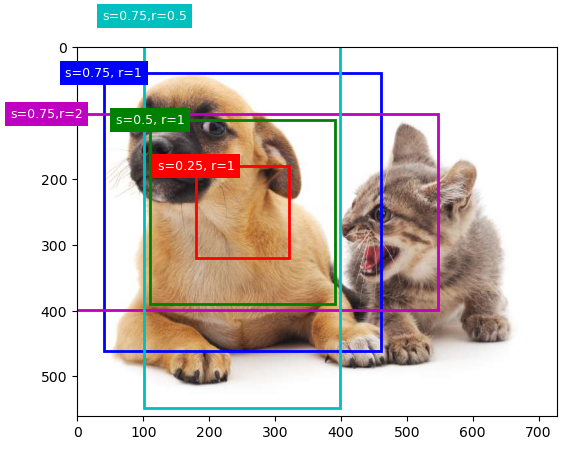

In [6]:
bbox_scale = torch.tensor((w,h,w,h)) 
fig = plt.imshow(img) 
print("fig.axes：",fig.axes)
print("boxes[250,250,:,:]：\n",boxes[250,250,:,:])
print("bbox_scale：", bbox_scale)
print("boxes[250,250,:,:] * bbox_scale：\n",boxes[250,250,:,:] * bbox_scale)
# 画出以250×250像素为中心的不同高宽比的五个锚框
show_bboxes(fig.axes, boxes[250,250,:,:] * bbox_scale, ['s=0.75, r=1','s=0.5, r=1','s=0.25, r=1','s=0.75,r=2','s=0.75,r=0.5']) 
plt.show()